# SNWD Reconstruction Using Pre-computed PCA Components


In [ ]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import pickle

# Load SNWD data
try:
    df = dd.read_parquet("../../../weather_data/stations_weather_with_dist2coast.parquet")
except FileNotFoundError:
    df = dd.read_parquet("../../../weather_data/joined_stations_weather.parquet")

snwd_df = df[df['ELEMENT'] == 'SNWD'].compute()
print(f"Loaded {len(snwd_df)} SNWD records")


Loaded 1015287 SNWD records
PCA components: (10, 365)
Explained variances: (10,)
Mean values: (365,)
First 10 components: 100.0% variance


IndexError: index 19 is out of bounds for axis 0 with size 10

In [6]:

# Load PCA components (top 10 eigenvectors)
with open('../weather_info/pca_results/snwd_pca_results.pkl', 'rb') as f:
    pca_results = pickle.load(f)

components = pca_results['components']  # Top 10 eigenvectors
explained_variances = pca_results['explained_variances']  # All eigenvalues
mean_values = pca_results['mean']

print(f"PCA components (top 10): {components.shape}")
print(f"Explained variances (all): {explained_variances.shape}")
print(f"Mean values: {mean_values.shape}")

# Analyze explained variance for top 10 components
explained_variance_ratio = explained_variances / np.sum(explained_variances)
top10_variance = np.sum(explained_variance_ratio[:10])

print(f"Top 10 components explain: {top10_variance:.1%} of total variance")
print(f"Individual component variance:")
for i in range(min(10, len(explained_variance_ratio))):
    print(f"  PC{i+1}: {explained_variance_ratio[i]:.1%}")


PCA components (top 10): (10, 365)
Explained variances (all): (10,)
Mean values: (365,)
Top 10 components explain: 100.0% of total variance
Individual component variance:
  PC1: 80.4%
  PC2: 7.2%
  PC3: 3.6%
  PC4: 3.0%
  PC5: 1.8%
  PC6: 1.1%
  PC7: 0.9%
  PC8: 0.8%
  PC9: 0.6%
  PC10: 0.5%


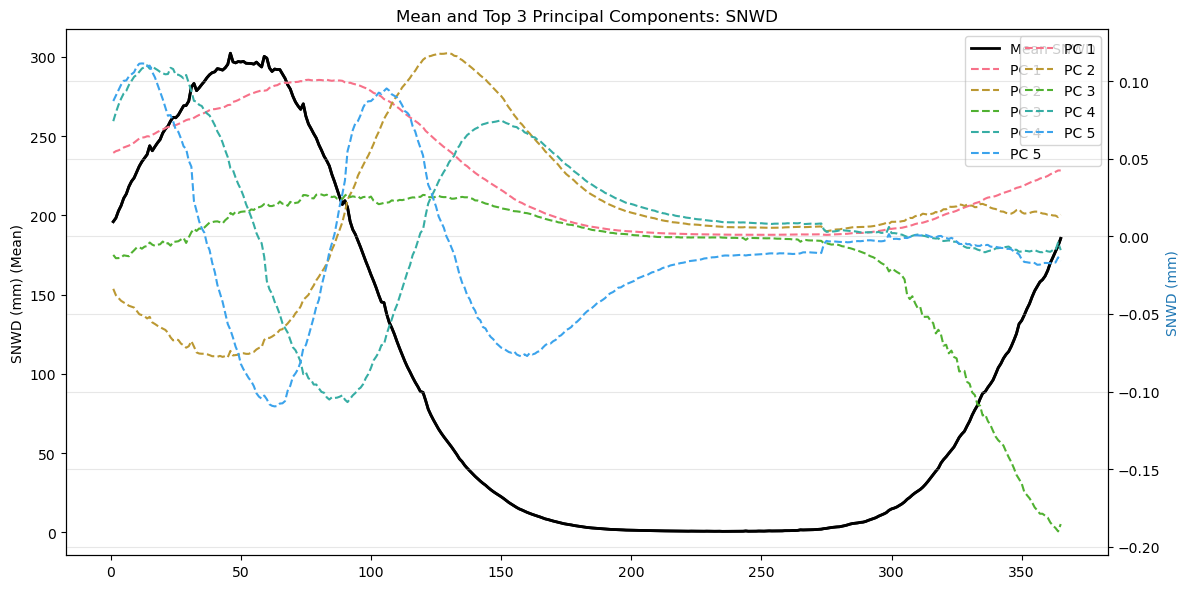

In [15]:
import sys
import os
# Plot mean and top 3 PCs for SNWD

# Make sure we have matplotlib, numpy, and the components/mean from previous cell

# Prepare x-axis: 1..365 (days of year)
days = np.arange(1, mean_values.shape[0] + 1)

plt.figure(figsize=(12, 6))

# Plot the mean SNWD signal
plt.plot(days, mean_values, label="Mean SNWD", color="black", linewidth=2)

# Plot mean on primary y-axis and top 3 principal components on secondary y-axis
ax1 = plt.gca()
mean_line, = ax1.plot(days, mean_values, label="Mean SNWD", color="black", linewidth=2)
ax1.set_ylabel("SNWD (mm) (Mean)", color="black")

# Create secondary y-axis for PCs
ax2 = ax1.twinx()
pc_lines = []
for i in range(5):
    pc = components[i]
    l, = ax2.plot(days, pc, label=f"PC {i+1}", linestyle="--")
    pc_lines.append(l)
ax2.set_ylabel("Principal Component Value", color="tab:blue")

# Combine legends from both axes
lines = [mean_line] + pc_lines
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper right")

plt.xlabel("Day of Year")
plt.ylabel("SNWD (mm)")
plt.title("Mean and Top 3 Principal Components: SNWD")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



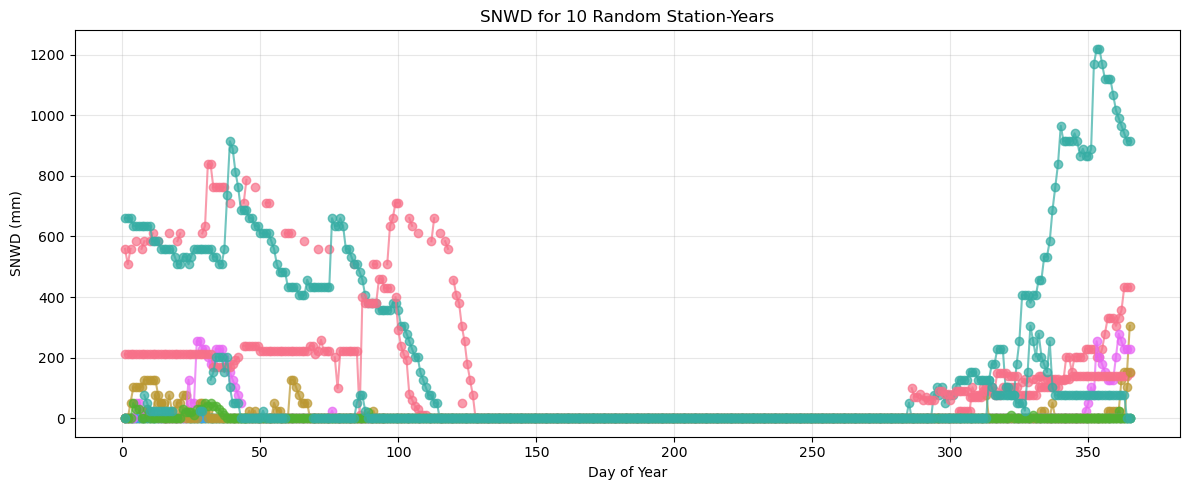

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Select 10 rows at random from snwd_df
random_rows = snwd_df.sample(n=10, random_state=np.random.randint(0, 10000))

# Extract the columns corresponding to days of year (assuming 'day_1', ..., 'day_365')
day_cols = [col for col in snwd_df.columns if col.startswith('day_') and col[4:].isdigit()]
day_cols_sorted = sorted(day_cols, key=lambda x: int(x.split('_')[1]))

days = np.arange(1, len(day_cols_sorted) + 1)

plt.figure(figsize=(12, 5))
for idx, (_, row) in enumerate(random_rows[day_cols_sorted].iterrows()):
    plt.plot(days, row.values, marker='o', label=f'Station-Year {idx+1}', alpha=0.7)
plt.xlabel('Day of Year')
plt.ylabel('SNWD (mm)')
plt.title('SNWD for 10 Random Station-Years')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



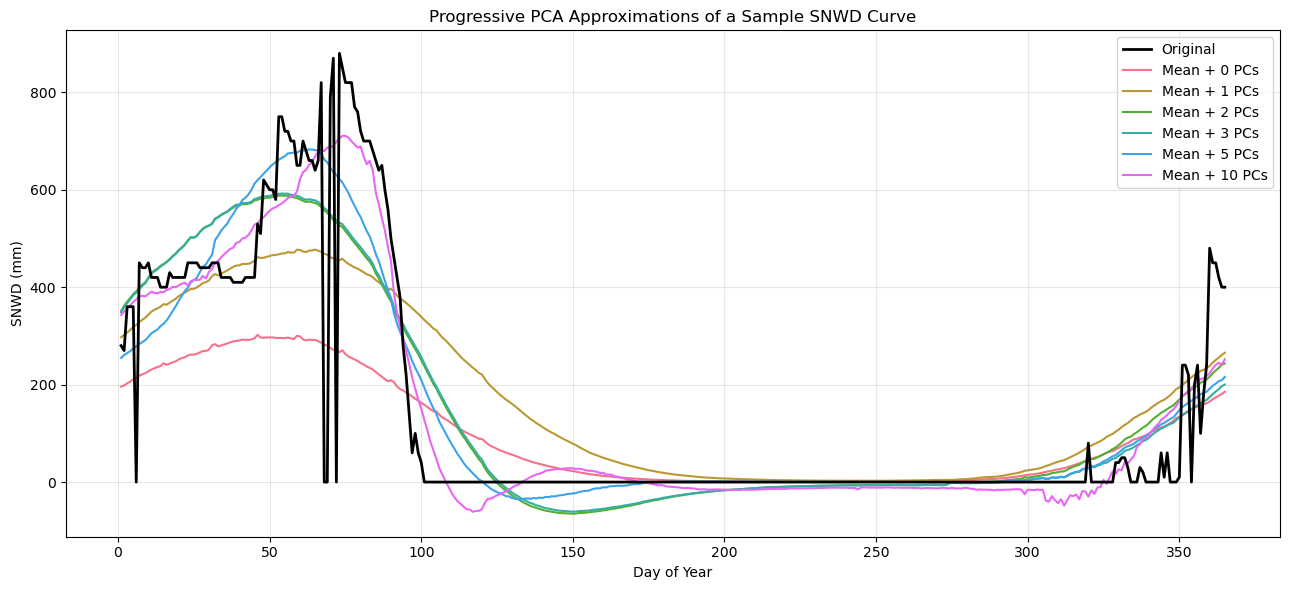

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# Pick a single random row from snwd_df
random_row = snwd_df.sample(n=1, random_state=np.random.randint(0, 10000))
row_values = random_row[day_cols_sorted].values.flatten()
row_values = np.nan_to_num(row_values, nan=0.0)

# Project the selected row onto the PCA components
row_centered = row_values - mean_values

# Store approximations
approximations = []

# Add mean-only approximation
approx = mean_values.copy()
approximations.append(approx)

# For progressively adding each PC
num_pcs = components.shape[0]
coeffs = []
for i in range(num_pcs):
    pc = components[i]
    coeff = np.dot(row_centered, pc)
    coeffs.append(coeff)
    approx = mean_values + sum(coeffs[j] * components[j] for j in range(i+1))
    approximations.append(approx)

# Plot the original and approximations
plt.figure(figsize=(13, 6))
plt.plot(days, row_values, label='Original', color='black', linewidth=2, zorder=3)
for k in [0,1,2, 3, 5, 10]:
    if k <= num_pcs:
        plt.plot(days, approximations[k], label=f"Mean + {k} PCs")

plt.xlabel('Day of Year')
plt.ylabel('SNWD (mm)')
plt.title("Progressive PCA Approximations of a Sample SNWD Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

